In [59]:
from CLEAN.utils import *
from app.src.CLEAN.model import LayerNormNet
import subprocess
import torch
import torch.nn.functional as F


In [24]:
import sys
print(sys.path)
sys.path.append('/home/sarrah/clean/CLEAN')
print(sys.path)



['/home/sarrah/clean/CLEAN/app/testing', '/home/sarrah/miniconda3/envs/clean/lib/python310.zip', '/home/sarrah/miniconda3/envs/clean/lib/python3.10', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/lib-dynload', '', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/site-packages', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/site-packages/CLEAN-0.1-py3.10.egg']
['/home/sarrah/clean/CLEAN/app/testing', '/home/sarrah/miniconda3/envs/clean/lib/python310.zip', '/home/sarrah/miniconda3/envs/clean/lib/python3.10', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/lib-dynload', '', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/site-packages', '/home/sarrah/miniconda3/envs/clean/lib/python3.10/site-packages/CLEAN-0.1-py3.10.egg', '/home/sarrah/clean/CLEAN']


In [3]:
csv_to_fasta("/home/sarrah/clean/CLEAN/app/data/datasets/halogenase.csv", "/home/sarrah/clean/CLEAN/app/data/datasets/halogenase.fasta")

In [63]:
def retrieve_esm1b_embedding(fasta_name):
    esm_script = "/home/sarrah/clean/CLEAN/app/esm/scripts/extract.py"
    esm_out = "/home/sarrah/clean/CLEAN/app/data/esm_data"
    esm_type = "esm1b_t33_650M_UR50S"
    fasta_name = "/home/sarrah/clean/CLEAN/app/data/datasets/" + fasta_name + ".fasta"
    command = ["python", esm_script, esm_type, 
              fasta_name, esm_out, "--include", "mean"]
    subprocess.run(command)

In [10]:
retrieve_esm1b_embedding("halogenase")

Transferred model to GPU
Read /home/sarrah/clean/CLEAN/app/data/datasets/halogenase.fasta with 37 sequences
Processing 1 of 5 batches (13 sequences)
Processing 2 of 5 batches (9 sequences)
Processing 3 of 5 batches (7 sequences)
Processing 4 of 5 batches (7 sequences)
Processing 5 of 5 batches (1 sequences)


In [11]:
#defined the specific train_data to use. may want to change eventually
id_ec_test, _ = get_ec_id_dict('/home/sarrah/clean/CLEAN/app/data/datasets/halogenase.csv')

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
model = LayerNormNet(512, 128, device, dtype)

In [32]:
checkpoint = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/split100.pth', map_location=device)

In [35]:
model.load_state_dict(checkpoint)
model.eval()


LayerNormNet(
  (fc1): Linear(in_features=1280, out_features=512, bias=True)
  (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [46]:
def load_esm(lookup):
    esm = format_esm(torch.load('/home/sarrah/clean/CLEAN/app/data/esm_data/' + lookup + '.pt'))
    return esm.unsqueeze(0)

def model_embedding_test_new(id_ec_test, model, device, dtype):
    '''
    Instead of loading esm embedding in the sequence of EC numbers
    the test embedding is loaded in the sequence of queries
    then inferenced with model to get model embedding
    '''
    ids_for_query = list(id_ec_test.keys())
    esm_to_cat = [load_esm(id) for id in ids_for_query]
    esm_emb = torch.cat(esm_to_cat).to(device=device, dtype=dtype)
    model_emb = model(esm_emb)
    return model_emb

In [47]:
emb_test = model_embedding_test_new(id_ec_test, model, device, dtype)

In [48]:
emb_test.shape

torch.Size([37, 128])

In [50]:
emb_test[0].shape

torch.Size([128])

In [52]:
num_testseqs = len(id_ec_test.keys())

In [60]:
emb_test = F.normalize(emb_test, dim=-1, p=2)
distances = torch.cdist(emb_test, emb_test, p=2)

In [61]:
distances.shape

torch.Size([37, 37])

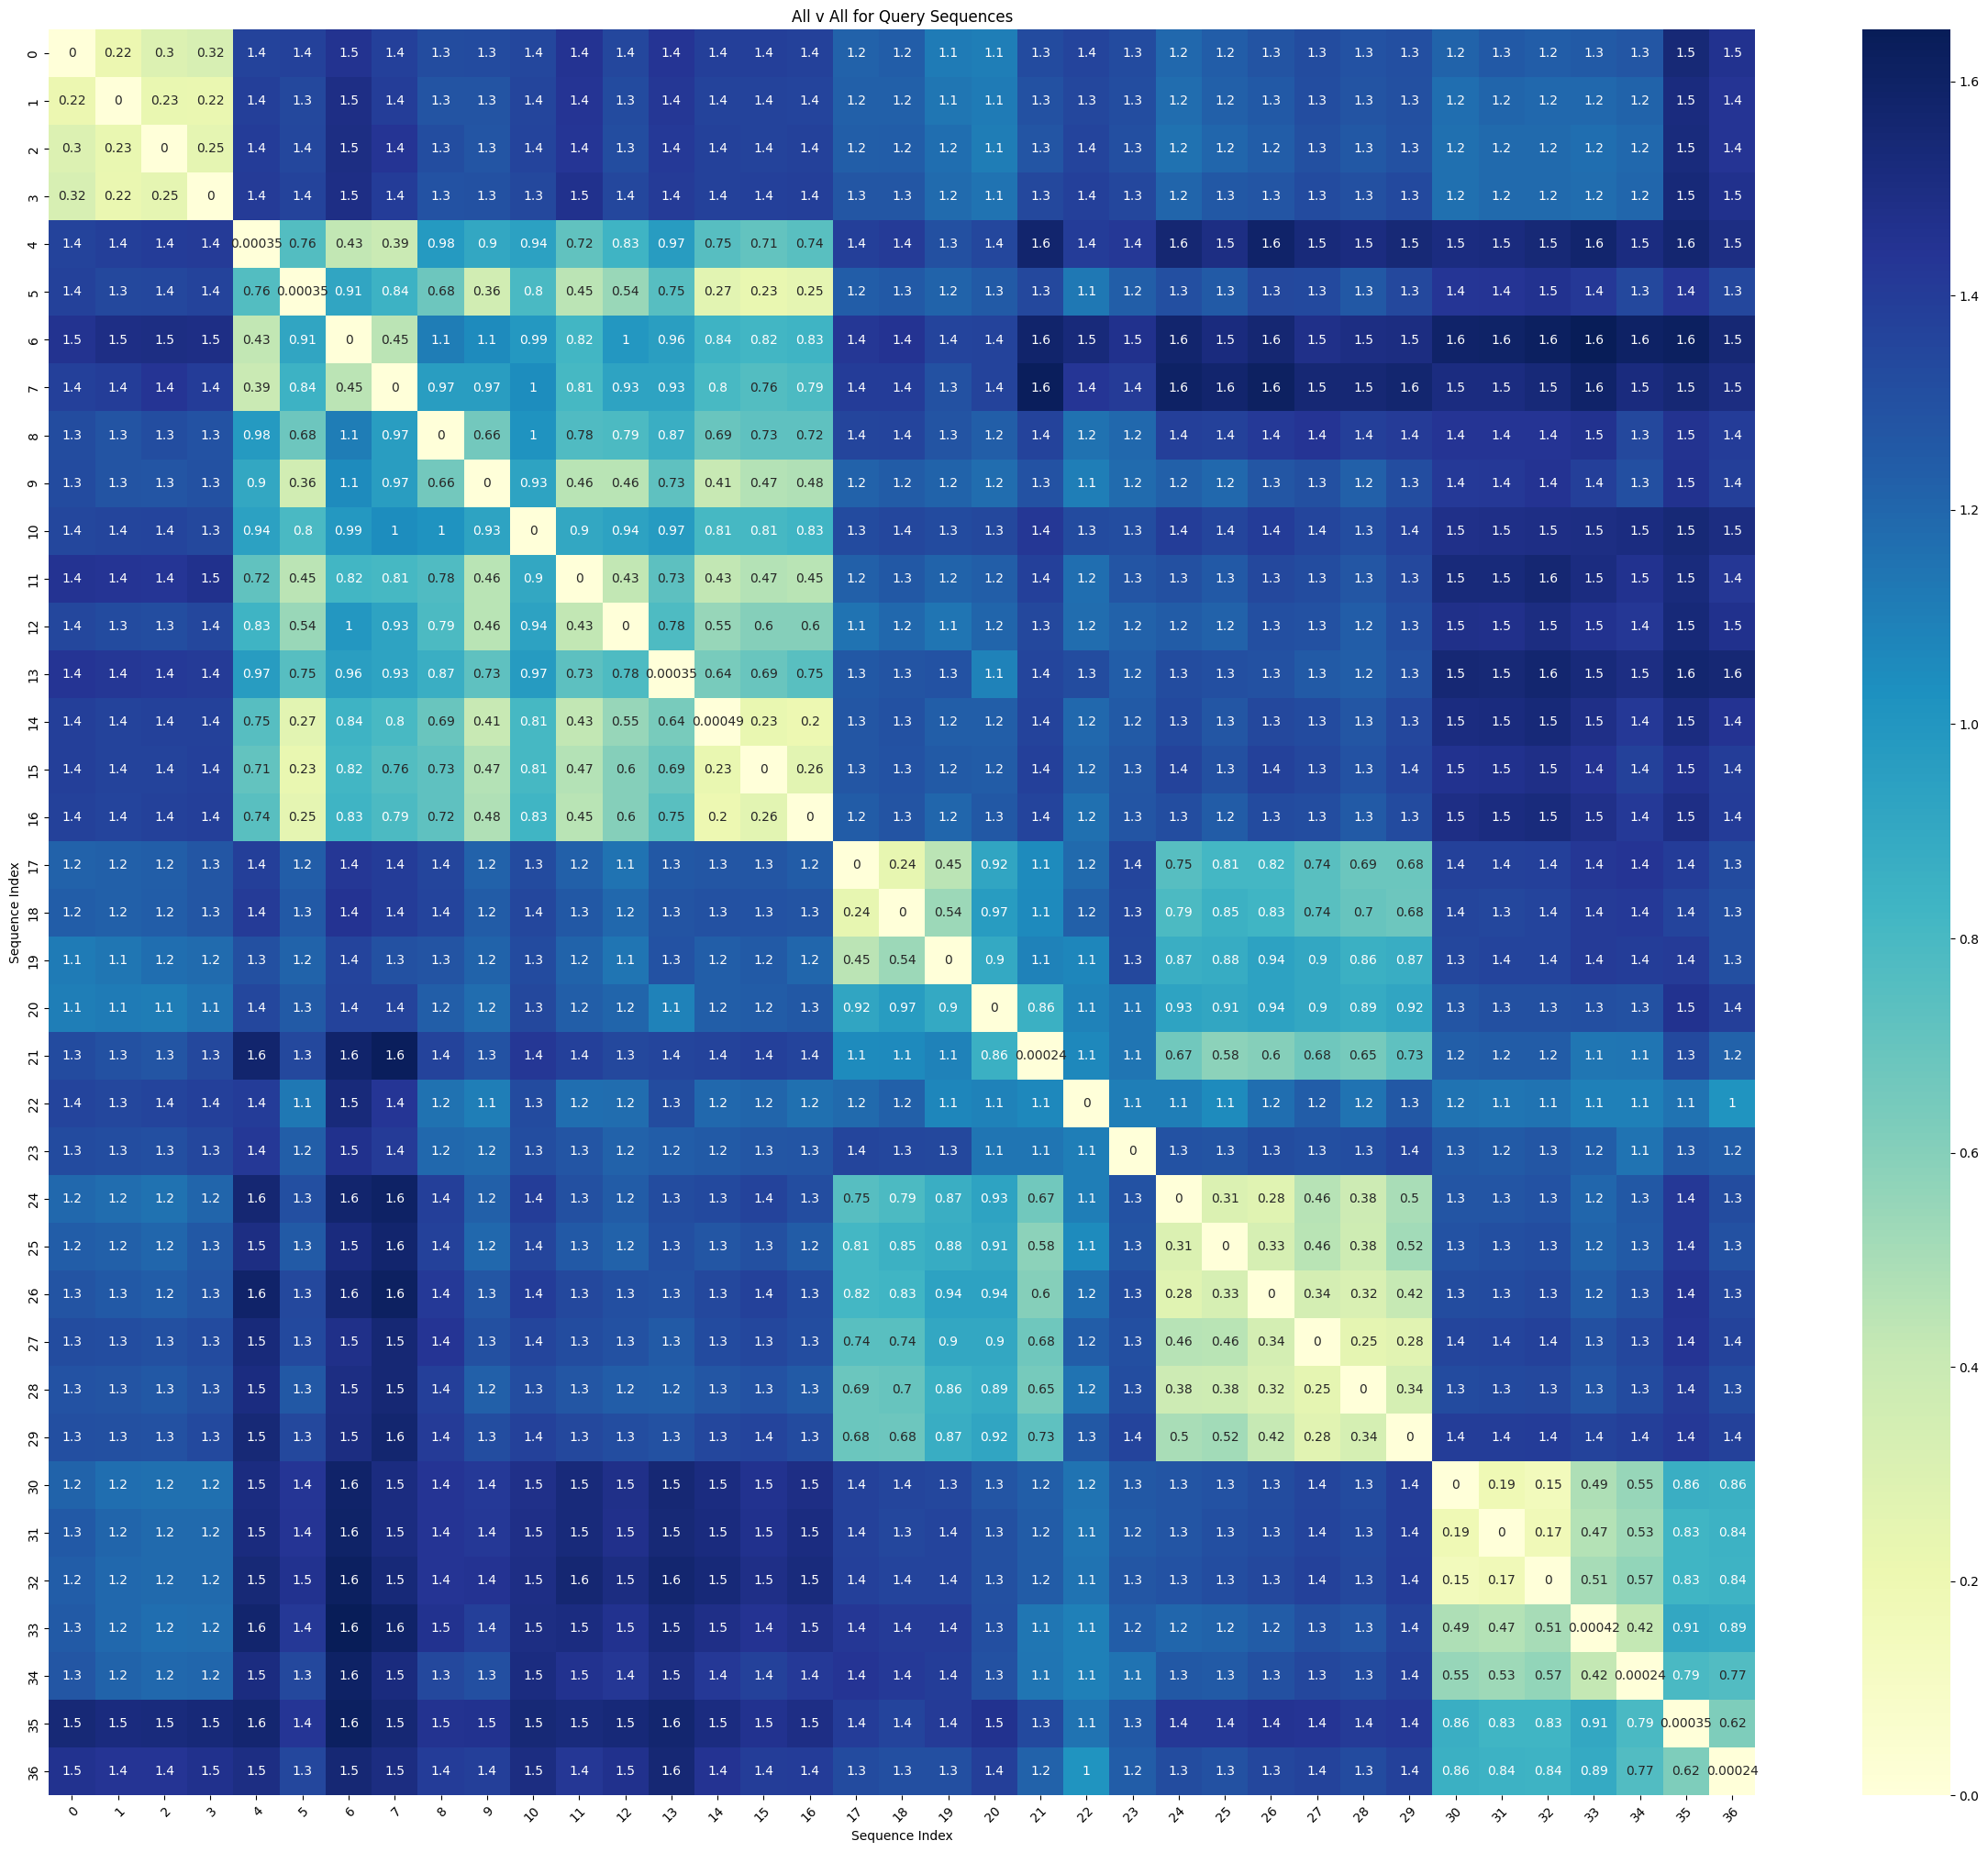

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
fig, ax = plt.subplots(figsize=(30, 25))
sns.heatmap(distances, annot=True, cmap="YlGnBu", ax=ax)

# Add title and axis labels
ax.set_title(f"All v All for Query Sequences")
ax.set_xlabel("Sequence Index")
ax.set_ylabel("Sequence Index")

# Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Show the heatmap
plt.show()